In [ ]:
import numpy as np
from ikpy.chain import Chain
from ikpy.link import URDFLink
from scipy.spatial.transform import Rotation as R
from ikpy.utils import geometry

joint_limits_min = np.array([-166, -101, -166, -176, -166, -1, -166])
joint_limits_max = np.array([166, 101, 166, -4, 166, 215, 166])
lims_min_safe = joint_limits_min + 1
lims_max_safe = joint_limits_max -1
joint_limits_rad_min = np.radians(lims_min_safe)
joint_limits_rad_max = np.radians(lims_max_safe)
prev_angle = np.random.uniform(joint_limits_rad_min, joint_limits_rad_max).tolist()

franka_chain = Chain.from_urdf_file(
    "franka.urdf",
    base_elements=["panda_panda_link0"],
    last_link_vector=np.array([0, 0, 0.045]),
    active_links_mask = [False, True, True, True, True, True, True, True, False, False, False, False]
)
#set bounds
for i in range(len(joint_limits_rad_min)):
    franka_chain.links[i + 1].bounds = (joint_limits_rad_min[i], joint_limits_rad_max[i])


validity_time = 0
setup_time = 0
solve_time = 0

In [ ]:
#!/usr/bin/env python
"""Example demonstrating collision detection and shortest distance queries."""

import time
import numpy as np
import pybullet as pyb
import pybullet_data
import pyb_utils

TIMESTEP = 1.0 / 60
all_x, all_y, all_z = [],[],[]
def load_environment(client_id, difficulty):
    if difficulty == 1:
        pyb.setTimeStep(TIMESTEP, physicsClientId=client_id)
        pyb.setAdditionalSearchPath(
            pybullet_data.getDataPath(), physicsClientId=client_id
        )

        # ground plane
        ground_id = pyb.loadURDF(
            "plane.urdf", [0, 0, 0], useFixedBase=True, physicsClientId=client_id
        )

        # KUKA iiwa robot arm (franka)
        franka_id = pyb.loadURDF(
            "franka.urdf",
            [0, 0, 0],
            useFixedBase=True,
            physicsClientId=client_id,
        )
        robot = pyb_utils.Robot(franka_id, client_id=client_id)
        for i in range(pyb.getNumJoints(franka_id)):
            joint_info = pyb.getJointInfo(franka_id, i)
            joint_name = joint_info[1].decode("utf-8")
            if joint_name == "panda_finger_joint1" or joint_name == "panda_finger_joint2":
                pyb.resetJointState(franka_id, i, 0.04, physicsClientId=client_id)

        # some cubes for obstacles
        cube1_id = pyb.loadURDF(
            "WallObstacle.urdf", useFixedBase=True, physicsClientId=client_id
        )
        targetcube = pyb.loadURDF(
            "TargetCube.urdf",
            [0, 0.5, 0.1],
            useFixedBase=True,
            physicsClientId=client_id,
        )

        obstacles = {
            "ground": ground_id,
            "cube1": cube1_id,
            "targetcube": targetcube
        }
        return robot, obstacles
    elif difficulty == 2:
        pyb.setTimeStep(TIMESTEP, physicsClientId=client_id)
        pyb.setAdditionalSearchPath(
            pybullet_data.getDataPath(), physicsClientId=client_id
        )

        # ground plane
        ground_id = pyb.loadURDF(
            "plane.urdf", [0, 0, 0], useFixedBase=True, physicsClientId=client_id
        )

        # Roboter
        franka_id = pyb.loadURDF(
            "franka.urdf",
            [0, 0, 0],
            useFixedBase=True,
            physicsClientId=client_id,
        )
        robot = pyb_utils.Robot(franka_id, client_id=client_id)
        for i in range(pyb.getNumJoints(franka_id)):
            joint_info = pyb.getJointInfo(franka_id, i)
            joint_name = joint_info[1].decode("utf-8")
            if joint_name in ("panda_finger_joint1", "panda_finger_joint2"):
                pyb.resetJointState(franka_id, i, 0.04, physicsClientId=client_id)

        # ---- Konvexe Dekomposition vorbereiten ----
        mesh_path = "meshes/SM_BucketPlastic_B.obj"
        vhacd_output = "meshes/mesh_vhacd.obj"
        # Führe VHACD nur einmal aus
        if not os.path.exists(vhacd_output):
            pyb.vhacd(mesh_path, vhacd_output, "vhacd_log.txt")

        # Lade VHACD-Ergebnis als Hindernis (direkt als Visual+Collision Shape)
        visual_shape = pyb.createVisualShape(pyb.GEOM_MESH, fileName=vhacd_output, meshScale=[0.01, 0.01, 0.003], physicsClientId=client_id)
        collision_shape = pyb.createCollisionShape(pyb.GEOM_MESH, fileName=vhacd_output, meshScale=[0.01, 0.01, 0.003], physicsClientId=client_id)

        cube1_id = pyb.createMultiBody(
            baseMass=0,
            baseCollisionShapeIndex=collision_shape,
            baseVisualShapeIndex=visual_shape,
            basePosition=[0, 0.5, 0],
            useMaximalCoordinates=True,
            physicsClientId=client_id
        )



        targetcube = pyb.loadURDF(
            "TargetCube.urdf",
            [0, 0.5, 0.1],
            useFixedBase=True,
            physicsClientId=client_id,
        )
        obstacles = {
            "ground": ground_id,
            "cube1": cube1_id,
            "targetcube": targetcube
        }
        return robot, obstacles

    elif difficulty == 3:
        pyb.setTimeStep(TIMESTEP, physicsClientId=client_id)
        pyb.setAdditionalSearchPath(
            pybullet_data.getDataPath(), physicsClientId=client_id
        )

        # ground plane
        ground_id = pyb.loadURDF(
            "plane.urdf", [0, 0, 0], useFixedBase=True, physicsClientId=client_id
        )

        # Roboter
        franka_id = pyb.loadURDF(
            "franka.urdf",
            [0, 0, 0],
            useFixedBase=True,
            physicsClientId=client_id,
        )
        robot = pyb_utils.Robot(franka_id, client_id=client_id)
        for i in range(pyb.getNumJoints(franka_id)):
            joint_info = pyb.getJointInfo(franka_id, i)
            joint_name = joint_info[1].decode("utf-8")
            if joint_name in ("panda_finger_joint1", "panda_finger_joint2"):
                pyb.resetJointState(franka_id, i, 0.04, physicsClientId=client_id)

        # ---- Konvexe Dekomposition vorbereiten ----
        mesh_path = "meshes/SM_BucketPlastic_B.obj"
        vhacd_output = "meshes/mesh_vhacd.obj"
        # Führe VHACD nur einmal aus
        if not os.path.exists(vhacd_output):
            pyb.vhacd(mesh_path, vhacd_output, "vhacd_log.txt")

        # Lade VHACD-Ergebnis als Hindernis (direkt als Visual+Collision Shape)
        visual_shape = pyb.createVisualShape(pyb.GEOM_MESH, fileName=vhacd_output, meshScale=[0.01, 0.01, 0.005], physicsClientId=client_id)
        collision_shape = pyb.createCollisionShape(pyb.GEOM_MESH, fileName=vhacd_output, meshScale=[0.01, 0.01, 0.005], physicsClientId=client_id)

        cube1_id = pyb.createMultiBody(
            baseMass=0,
            baseCollisionShapeIndex=collision_shape,
            baseVisualShapeIndex=visual_shape,
            basePosition=[0, 0.5, 0],
            useMaximalCoordinates=True,
            physicsClientId=client_id
        )
        cube2_id = pyb.createMultiBody(
            baseMass=0,
            baseCollisionShapeIndex=collision_shape,
            baseVisualShapeIndex=visual_shape,
            basePosition=[0.5, 0, 0],
            useMaximalCoordinates=True,
            physicsClientId=client_id
        )
        targetcube = pyb.loadURDF(
            "TargetCube.urdf",
            [0, 0.5, 0.1],
            useFixedBase=True,
            physicsClientId=client_id,
        )

        obstacles = {
            "ground": ground_id,
            "cube1": cube1_id,
            "cube2": cube2_id,
            "targetcube": targetcube
        }
        return robot, obstacles

    elif difficulty == 4:
        pyb.setTimeStep(TIMESTEP, physicsClientId=client_id)
        pyb.setAdditionalSearchPath(
            pybullet_data.getDataPath(), physicsClientId=client_id
        )

        # ground plane
        ground_id = pyb.loadURDF(
            "plane.urdf", [0, 0, 0], useFixedBase=True, physicsClientId=client_id
        )

        # Roboter
        franka_id = pyb.loadURDF(
            "franka.urdf",
            [0, 0, 0],
            useFixedBase=True,
            physicsClientId=client_id,
        )
        robot = pyb_utils.Robot(franka_id, client_id=client_id)
        for i in range(pyb.getNumJoints(franka_id)):
            joint_info = pyb.getJointInfo(franka_id, i)
            joint_name = joint_info[1].decode("utf-8")
            if joint_name in ("panda_finger_joint1", "panda_finger_joint2"):
                pyb.resetJointState(franka_id, i, 0.04, physicsClientId=client_id)

        # ---- Konvexe Dekomposition vorbereiten ----
        mesh_path = "meshes/SM_BucketPlastic_B.obj"
        vhacd_output = "meshes/mesh_vhacd.obj"
        # Führe VHACD nur einmal aus
        if not os.path.exists(vhacd_output):
            pyb.vhacd(mesh_path, vhacd_output, "vhacd_log.txt")

        # Lade VHACD-Ergebnis als Hindernis (direkt als Visual+Collision Shape)
        visual_shape = pyb.createVisualShape(pyb.GEOM_MESH, fileName=vhacd_output, meshScale=[0.01, 0.01, 0.003], physicsClientId=client_id)
        collision_shape = pyb.createCollisionShape(pyb.GEOM_MESH, fileName=vhacd_output, meshScale=[0.01, 0.01, 0.003], physicsClientId=client_id)

        cube1_id = pyb.createMultiBody(
            baseMass=0,
            baseCollisionShapeIndex=collision_shape,
            baseVisualShapeIndex=visual_shape,
            basePosition=[0, 0.5, 0],
            useMaximalCoordinates=True,
            physicsClientId=client_id
        )

        targetcube = pyb.loadURDF(
            "TargetCube.urdf",
            [0, 0.5, 0.1],
            useFixedBase=True,
            physicsClientId=client_id,
        )

        obstacles = {
            "ground": ground_id,
            "cube1": cube1_id,
            "targetcube": targetcube
        }
        return robot, obstacles


def calculate_state_validity(current_joint_state, env_num):
    global validity_time
    start_validity_time = time.time()
    if len(current_joint_state) == 7:
        full_angles = franka_chain.active_to_full(current_joint_state, np.zeros(len(franka_chain.links)))
    elif len(current_joint_state) == 12:
        full_angles = current_joint_state
    else:
        raise ValueError("Invalid joint state length")

    #full_angles = franka_chain.active_to_full(current_joint_state, np.zeros(len(franka_chain.links)))
    current_fk = franka_chain.forward_kinematics(full_angles)
    x, y, z = current_fk[:3, 3]
    all_x.append(x)
    all_y.append(y)
    all_z.append(z)

    # Nur ein DIRECT-Client für Kollisionserkennung
    col_id = pyb.connect(pyb.DIRECT)

    # Lade Umgebung
    col_robot, col_obstacles = load_environment(col_id, env_num)
    obstacles = list(col_obstacles.values())

    # Links des Roboters (Namen so wie im original)
    link = []
    link.append((col_robot.uid, "panda_panda_link1"))
    link.append((col_robot.uid, "panda_panda_link2"))
    link.append((col_robot.uid, "panda_panda_link3"))
    link.append((col_robot.uid, "panda_panda_link4"))
    link.append((col_robot.uid, "panda_panda_link5"))
    link.append((col_robot.uid, "panda_panda_link6"))
    link.append((col_robot.uid, "panda_panda_link7"))
    link.append((col_robot.uid, "panda_panda_hand"))
    link.append((col_robot.uid, "panda_panda_leftfinger"))
    link.append((col_robot.uid, "panda_panda_rightfinger"))
    collision_pairs = []
    for link_idx in link:
        for obs in obstacles:
            collision_pairs.append((obs, link_idx))

    col_detector = pyb_utils.CollisionDetector(
        col_id,
        collision_pairs
    )

    # Setze Gelenkzustand im kollisions-Client
    print(current_joint_state)
    col_robot.reset_joint_configuration(current_joint_state)
    # Prüfe Kollision (Margin fest auf 0.01 gesetzt)
    if not col_detector.in_collision(margin=0.01):
        pyb.disconnect(col_id)
        print(f"State valid")
        validity_time += time.time() - start_validity_time
        return True
    else:
        pyb.disconnect(col_id)
        print(f"State invalid")
        validity_time += time.time() - start_validity_time
        return False


if __name__ == "__main__":
    current_state = [ 0.49749239, -0.39204911, -0.38585028, -1.32839171,  1.41997276,
  0.3847102,  -1.79493424]

    #valid = calculate_state_validity(current_state)



pybullet build time: Jun 10 2025 11:09:21


In [ ]:
import sys
import time
try:
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
except ImportError:
    # if the ompl module is not in the PYTHONPATH assume it is installed in a
    # subdirectory of the parent directory called "py-bindings."
    from os.path import abspath, dirname, join
    sys.path.insert(0, join(dirname(dirname(abspath(__file__))), 'py-bindings'))
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
from math import sqrt
import argparse

j = 0
tested_joint_states = []
class ValidityChecker(ob.StateValidityChecker):
    def __init__(self, si, min_distance):
        super(ValidityChecker, self).__init__(si)
        self.min_distance = min_distance
    # Returns whether the given state's position overlaps the
    # circular obstacle

    def isValid(self, state):
        joint_angles = [state[i] for i in range(7)]
        global j
        j = j+1
        #full_angles = franka_chain.active_to_full(joint_angles, np.zeros(len(franka_chain.links)))
        # current_fk = franka_chain.forward_kinematics(full_angles)
        # x, y, z = current_fk[:3, 3]
        # all_x.append(x)
        # all_y.append(y)
        # all_z.append(z)
        valid = calculate_state_validity(joint_angles, env_num)
        tested_joint_states.append(joint_angles[:])
        if not valid:
            print(f"Invalid state: {joint_angles}")
        return valid
        #return True

    # Returns the distance from the given state's position to the
    # boundary of the circular obstacle.
    def clearance(self, state):
        # Extract the robot's (x,y) position from its state
        print("hallo")
        x = state[0]
        y = state[1]
        z = state[2]




        # Distance formula between three points, offset by the circle's
        # radius
        return sqrt((x - 0.5)**2 + (y - 0.5)**2 + (z - 0.5)**2) - 0.05

    def checkCollisions(self, state):
        pass

## Returns a structure representing the optimization objective to use
#  for optimal motion planning. This method returns an objective
#  which attempts to minimize the length in configuration space of
#  computed paths.
def getPathLengthObjective(si):
    return ob.PathLengthOptimizationObjective(si)

## Returns an optimization objective which attempts to minimize path
#  length that is satisfied when a path of length shorter than 1.51
#  is found.
def getThresholdPathLengthObj(si):
    obj = ob.PathLengthOptimizationObjective(si)
    obj.setCostThreshold(ob.Cost(1.51))
    return obj

## Defines an optimization objective which attempts to steer the
#  robot away from obstacles. To formulate this objective as a
#  minimization of path cost, we can define the cost of a path as a
#  summation of the costs of each of the states along the path, where
#  each state cost is a function of that state's clearance from
#  obstacles.
#
#  The class StateCostIntegralObjective represents objectives as
#  summations of state costs, just like we require. All we need to do
#  then is inherit from that base class and define our specific state
#  cost function by overriding the stateCost() method.
#
class ClearanceObjective(ob.StateCostIntegralObjective):
    def __init__(self, si):
        super(ClearanceObjective, self).__init__(si, True)
        self.si_ = si

    # Our requirement is to maximize path clearance from obstacles,
    # but we want to represent the objective as a path cost
    # minimization. Therefore, we set each state's cost to be the
    # reciprocal of its clearance, so that as state clearance
    # increases, the state cost decreases.
    def stateCost(self, s):
        return ob.Cost(1 / (self.si_.getStateValidityChecker().clearance(s) +
                            sys.float_info.min))

## Return an optimization objective which attempts to steer the robot
#  away from obstacles.
def getClearanceObjective(si):
    return ClearanceObjective(si)

## Create an optimization objective which attempts to optimize both
#  path length and clearance. We do this by defining our individual
#  objectives, then adding them to a MultiOptimizationObjective
#  object. This results in an optimization objective where path cost
#  is equivalent to adding up each of the individual objectives' path
#  costs.
#
#  When adding objectives, we can also optionally specify each
#  objective's weighting factor to signify how important it is in
#  optimal planning. If no weight is specified, the weight defaults to
#  1.0.
def getBalancedObjective1(si):
    lengthObj = ob.PathLengthOptimizationObjective(si)
    clearObj = ClearanceObjective(si)

    opt = ob.MultiOptimizationObjective(si)
    opt.addObjective(lengthObj, 5.0)
    opt.addObjective(clearObj, 1.0)

    return opt

## Create an optimization objective equivalent to the one returned by
#  getBalancedObjective1(), but use an alternate syntax.
#  THIS DOESN'T WORK YET. THE OPERATORS SOMEHOW AREN'T EXPORTED BY Py++.
# def getBalancedObjective2(si):
#     lengthObj = ob.PathLengthOptimizationObjective(si)
#     clearObj = ClearanceObjective(si)
#
#     return 5.0*lengthObj + clearObj


## Create an optimization objective for minimizing path length, and
#  specify a cost-to-go heuristic suitable for this optimal planning
#  problem.
def getPathLengthObjWithCostToGo(si):
    obj = ob.PathLengthOptimizationObjective(si)
    obj.setCostToGoHeuristic(ob.CostToGoHeuristic(ob.goalRegionCostToGo))
    return obj


# Keep these in alphabetical order and all lower case
def allocatePlanner(si, plannerType):
    if plannerType.lower() == "bfmtstar":
        return og.BFMT(si)
    elif plannerType.lower() == "bitstar":
        return og.BITstar(si)
    elif plannerType.lower() == "fmtstar":
        return og.FMT(si)
    elif plannerType.lower() == "informedrrtstar":
        return og.InformedRRTstar(si)
    elif plannerType.lower() == "prmstar":
        return og.PRMstar(si)
    elif plannerType.lower() == "rrtstar":
        return og.RRTstar(si)
    elif plannerType.lower() == "sorrtstar":
        return og.SORRTstar(si)
    else:
        ou.OMPL_ERROR("Planner-type is not implemented in allocation function.")


# Keep these in alphabetical order and all lower case
def allocateObjective(si, objectiveType):
    if objectiveType.lower() == "pathclearance":
        return getClearanceObjective(si)
    elif objectiveType.lower() == "pathlength":
        return getPathLengthObjective(si)
    elif objectiveType.lower() == "thresholdpathlength":
        return getThresholdPathLengthObj(si)
    elif objectiveType.lower() == "weightedlengthandclearancecombo":
        return getBalancedObjective1(si)
    else:
        ou.OMPL_ERROR("Optimization-objective is not implemented in allocation function.")



def plan(runTime, plannerType, objectiveType, interpolationnumber, min_distance, start_xyz, goal_xyz, max_runtime, optimizingTime, env_num):
    global validity_time, setup_time, solve_time
    start_setup_time = time.time()
    # 1. Setup des StateSpace
    space = ob.RealVectorStateSpace(7)
    bounds = ob.RealVectorBounds(7)
    for i in range(7):
        bounds.setLow(i, joint_limits_rad_min[i])
        bounds.setHigh(i, joint_limits_rad_max[i])
    space.setBounds(bounds)

    # 2. Inverse Kinematics für Start
    prev_angle =  [1, -0.38066329, 0.26839613, -2, 0.77729231, 2, 0.00391651, 0.79768890]
    full_prev_angle = franka_chain.active_to_full(prev_angle, np.zeros(len(franka_chain.links)))

    start_frame = np.eye(4)
    start_frame[:3, 3] = start_xyz
    start_frame[:3, :3] = R.from_euler('x', 180, degrees=True).as_matrix()
    joints_start = franka_chain.inverse_kinematics_frame(start_frame, initial_position=full_prev_angle)

    # 3. Inverse Kinematics für Goal
    target_frame = np.eye(4)
    target_frame[:3, 3] = goal_xyz
    target_frame[:3, :3] = R.from_euler('x', 180, degrees=True).as_matrix()
    joints_goal = franka_chain.inverse_kinematics_frame(target_frame, initial_position=full_prev_angle, orientation_mode="all")

    # Max. 10 Versuche, gültigen Startzustand zu finden
    for attempt in range(10):
        if calculate_state_validity(joints_start, env_num):
            break
        print(f"[Start-IK] Ungültiger Startzustand. Versuche neuen IK-Seed (Versuch {attempt+1}/10)")
        prev_angle = np.random.uniform(joint_limits_rad_min, joint_limits_rad_max).tolist()
        full_prev_angle = franka_chain.active_to_full(prev_angle, np.zeros(len(franka_chain.links)))
        joints_start = franka_chain.inverse_kinematics_frame(start_frame, initial_position=full_prev_angle)
    else:
        print("Fehler: Kein gültiger Startzustand nach 10 Versuchen.")
        return None, None, None, None

    # Max. 10 Versuche, gültigen Zielzustand zu finden
    for attempt in range(100):
        if calculate_state_validity(joints_goal, env_num):
            break
        print(f"[Ziel-IK] Ungültiger Zielzustand. Versuche neuen IK-Seed (Versuch {attempt+1}/10)")
        prev_angle = np.random.uniform(joint_limits_rad_min, joint_limits_rad_max).tolist()
        full_prev_angle = franka_chain.active_to_full(prev_angle, np.zeros(len(franka_chain.links)))
        joints_goal = franka_chain.inverse_kinematics_frame(target_frame, initial_position=full_prev_angle, orientation_mode="all")
    else:
        print("Fehler: Kein gültiger Zielzustand nach 10 Versuchen.")
        return None, None, None, None


    start = ob.State(space)
    for i in range(7):
        start[i] = joints_start[i+1]
    goal = ob.State(space)

    for i in range(7):
        goal[i] = joints_goal[i+1]

    fks=franka_chain.forward_kinematics(joints_start)
    fkg=franka_chain.forward_kinematics(joints_goal)
    print(joints_start, joints_goal)
    print(fks, fkg)

    # Construct a space information instance for this state space
    si = ob.SpaceInformation(space)

    # Set the object used to check which states in the space are valid
    validityChecker = ValidityChecker(si, min_distance)
    si.setStateValidityChecker(validityChecker)

    motion_validator = ob.DiscreteMotionValidator(si)
    si.setMotionValidator(motion_validator)
    si.setup()
    setup_time += time.time() - start_setup_time
    # Create a problem instance
    pdef = ob.ProblemDefinition(si)
    # Set the start and goal states
    pdef.setStartAndGoalStates(start, goal)

    # Create the optimization objective specified by our command-line argument.
    # This helper function is simply a switch statement.
    pdef.setOptimizationObjective(allocateObjective(si, objectiveType))

    # Construct the optimal planner specified by our command line argument.
    # This helper function is simply a switch statement.
    optimizingPlanner = allocatePlanner(si, plannerType)

    # Set the problem instance for our planner to solve
    optimizingPlanner.setProblemDefinition(pdef)
    optimizingPlanner.setup()


    # attempt to solve the planning problem in the given runtime
    start_solve_time = time.time()
    solved = optimizingPlanner.solve(runTime)
    solve_time += time.time() - start_solve_time

    start_time = time.time()
    while (str(solved) != "Exact solution"):
        if time.time() - start_time >= max_runtime:
            print("Maximale runtime erreicht! Keine exakte Lösung gefunden.")
            break
        solved = optimizingPlanner.solve(runTime)

    if str(solved) == "Exact solution":
        finish_time = time.time() - start_time
        print("Exakte lösung gefunden in: ", finish_time, " Sekunden")
        first_path = pdef.getSolutionPath()
        first_path.interpolate(interpolationnumber)
        first_path_states = first_path.getStates()
        first_sol = [[s[i] for i in range(7)] for s in first_path_states]
        print(first_sol)
        np.save("first_sol.npy", first_sol)
        initial_cost = pdef.getSolutionPath().cost(pdef.getOptimizationObjective()).value()
        print('{0} found solution of path length {1:.4f} with an optimization ' \
            'objective value of {2:.4f}'.format( \
            optimizingPlanner.getName(), \
            pdef.getSolutionPath().length(), \
            initial_cost))

        #optimiting Path
        optimizingPlanner.solve(optimizingTime)
        path = pdef.getSolutionPath()
        path.interpolate(interpolationnumber)

        cost = pdef.getSolutionPath().cost(pdef.getOptimizationObjective()).value()
        print('{0} found solution of path length {1:.4f} with an optimization ' \
            'objective value of {2:.4f}'.format( \
            optimizingPlanner.getName(), \
            pdef.getSolutionPath().length(), \
            cost))

        path_states = path.getStates()
        opt_sol = [[s[i] for i in range(7)] for s in path_states]

        return opt_sol, initial_cost, cost, finish_time
    else:
        print("No solution found.")
        return (None, None, None, None)

if __name__ == "__main__":
    runtime = 2.0
    plannerType = "RRTstar"
    objectiveType = "PathLength"
    interpolationnumber = 20
    min_distance = 0.01
    max_runtime = 120
    optimizingTime = 20

    # start_xyz = [0.1, 0.1, 0.85]
    # goal_xyz = [0.65, 0.3, 0.4]
    # points, cost = plan(runtime, plannerType, objectiveType, interpolationnumber, min_distance, start_xyz, goal_xyz, max_runtime, optimizingTime)
    # np.save("ompl_angles.npy", points)
    # print(points)
    # print(j)
    # np.save("tested_joint_states.npy", tested_joint_states)
## @endcond

In [ ]:
def run_planner(run_id, plannerType, objectiveType, start_xyz, goal_xyz, env_num,
                interpolationnumber=20, min_distance=0.01, max_runtime=200, optimizingTime=0):

    points, initial_cost, cost, time = plan(
        runTime=2.0,
        plannerType=plannerType,
        objectiveType=objectiveType,
        interpolationnumber=interpolationnumber,
        min_distance=min_distance,
        start_xyz=start_xyz,
        goal_xyz=goal_xyz,
        max_runtime=max_runtime,
        optimizingTime=optimizingTime,
        env_num = env_num
    )

    return {
        "run_id": run_id,
        "planner": plannerType,
        "objective": objectiveType,
        "initial_cost": initial_cost,
        "cost": cost,
        "path": points,
        "time": time,
        "success": points is not None,
        "validity_time": validity_time,
        "setup_time": setup_time,
        "solve_time": solve_time,
    }
#p = run_planner(1, "RRTstar", "PathLength", [0.1, 0.1, 0.85], [0.65, 0.3, 0.4])


In [ ]:
import os
import csv
results = []
repetitions = 5

planner = "rrtstar"
objective = "PathLength"
env_num = 2

if env_num == 1:
    # env 1 states
    start = [0.1, 0.1, 0.85]
    goal = [0, 0.5, 0.1]
    output_dir = "results_env1"
elif env_num == 2:
    # env 2 states
    start = [0.4, 0.4, 0.4]
    goal = [0, 0.5, 0.1]
    output_dir = "results_env2"
elif env_num == 3:
    # env 3 states
    start = [0.5, 0, 0.1]
    goal = [0, 0.5, 0.1]
    output_dir = "results_env3"
elif env_num == 4:
    # env 4 states
    start = [0, 0.3, 0.4]
    goal = [0.2, 0.45, 0.1] #invalid position (collision)
    output_dir = "results_env4"

os.makedirs(output_dir, exist_ok=True)

for i in range(repetitions):
    print(f"Run {i+1}/{repetitions} for {planner} + {objective}")
    result = run_planner(
        run_id=i,
        plannerType=planner,
        objectiveType=objective,
        start_xyz=start,
        goal_xyz=goal,
        env_num=env_num
    )
    results.append(result)

summary_path = os.path.join(output_dir, f"run_summary_{planner}.csv")
file_exists = os.path.isfile(summary_path)

with open(summary_path, 'a', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["run_id", "planner", "objective", "initial_cost", "cost", "time", "path", "validity_time", "setup_time", "solve_time"])
    if not file_exists:
        writer.writeheader()
    for result in results:
        writer.writerow({
            "run_id": result["run_id"],
            "planner": result["planner"],
            "objective": result["objective"],
            "initial_cost": result["initial_cost"],
            "cost": result["cost"],
            "time": result["time"],
            "path": result["path"],
            "validity_time": result["validity_time"],
            "setup_time": result["setup_time"],
            "solve_time": result["solve_time"],
        })


Run 1/5 for rrtstar + PathLength
[ 0.          0.62917966 -0.01931697  0.03418133 -1.94360122  0.43125168
  1.93887393 -1.41363133  0.          0.          0.          0.        ]
State valid
[ 0.          0.70082131  0.41333598  0.8139374  -2.36869153 -0.58386316
  2.58331914  1.19617592  0.          0.          0.          0.        ]
State valid
[ 0.          0.62917966 -0.01931697  0.03418133 -1.94360122  0.43125168
  1.93887393 -1.41363133  0.          0.          0.          0.        ] [ 0.          0.70082131  0.41333598  0.8139374  -2.36869153 -0.58386316
  2.58331914  1.19617592  0.          0.          0.          0.        ]
[[ 0.44324709  0.87264591 -0.20499058  0.40000002]
 [ 0.86973722 -0.3633077   0.33401301  0.40000001]
 [ 0.21700043 -0.32633823 -0.9200077   0.4       ]
 [ 0.          0.          0.          1.        ]] [[ 1.00000000e+00 -3.53573419e-12 -2.12494187e-11  1.54034104e-12]
 [-3.53545718e-12 -1.00000000e+00  4.75911892e-12  5.00000000e-01]
 [-2.12494889e-1

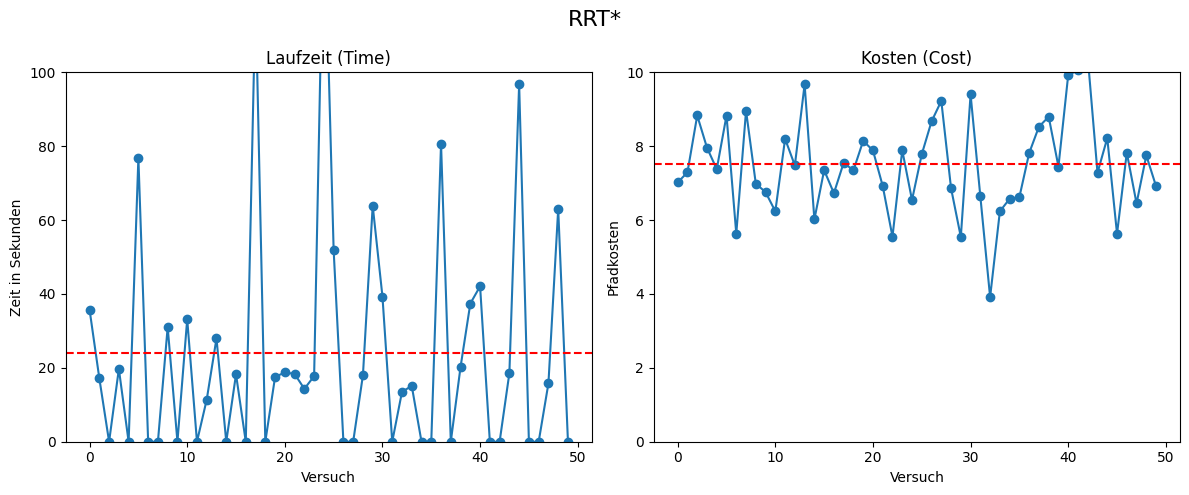

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

rrt = pd.read_csv("run_summary_prmstar.csv")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("RRT*", fontsize=16)
# Erster Plot: time
axs[0].plot(rrt["time"], marker='o', linestyle='-')
axs[0].axhline(rrt["time"].mean(), linestyle='--', color="red", label="Durchschnitt")
axs[0].set_title("Laufzeit (Time)")
axs[0].set_xlabel("Versuch")
axs[0].set_ylabel("Zeit in Sekunden")
axs[0].set_ylim(0, 100)

# Zweiter Plot: cost
axs[1].plot(rrt["initial_cost"], marker='o', linestyle='-')
axs[1].axhline(rrt["initial_cost"].mean(), linestyle='--', color="red", label="Durchschnitt")
axs[1].set_title("Kosten (Cost)")
axs[1].set_xlabel("Versuch")
axs[1].set_ylabel("Pfadkosten")
axs[1].set_ylim(0, 10)
plt.tight_layout()
plt.show()

12.767588724119543
15.61528743606563


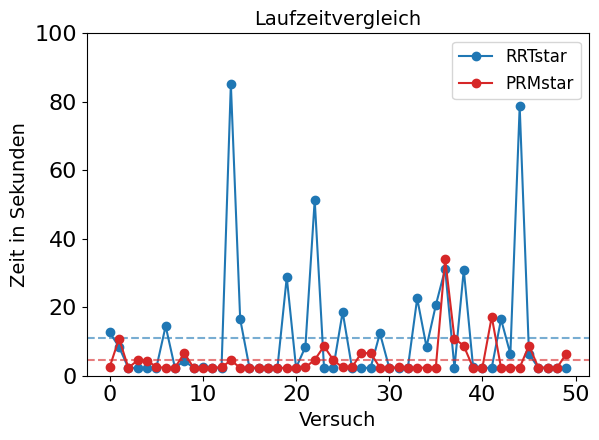

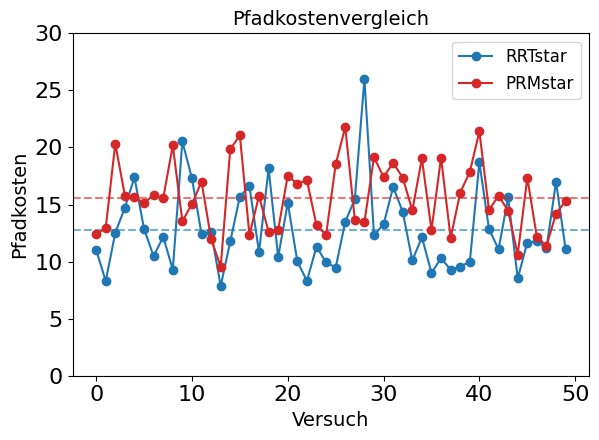

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Dictionary mit Namen und zugehörigen CSV-Dateien
algorithms = {
    "RRTstar": "run_summary_rrtstar.csv",
    "PRMstar": "run_summary_prmstar.csv",
}

# Speichere die erste Grafik (Laufzeit)
fig_laufzeit = plt.figure()
ax1 = fig_laufzeit.add_subplot(1, 1, 1)
for i, (name, path) in enumerate(algorithms.items()):
    df = pd.read_csv(path)
    ax1.plot(df["general_time"], label=f"{name}", marker='o', linestyle='-', color=colors[i])
    ax1.axhline(df["general_time"].mean(), linestyle='--', color=colors[i], alpha=0.6)

ax1.set_title("Laufzeitvergleich")
ax1.set_xlabel("Versuch")
ax1.set_ylabel("Zeit in Sekunden")
ax1.set_ylim(0, 100)
ax1.legend()
fig_laufzeit.tight_layout()
fig_laufzeit.savefig("laufzeitvergleich.png", dpi=300, bbox_inches='tight')

# Speichere die zweite Grafik (Pfadkosten)
fig_kosten = plt.figure()
ax2 = fig_kosten.add_subplot(1, 1, 1)
for i, (name, path) in enumerate(algorithms.items()):
    df = pd.read_csv(path)
    ax2.plot(df["initial_cost"], label=f"{name}", marker='o', linestyle='-', color=colors[i])
    ax2.axhline(df["initial_cost"].mean(), linestyle='--', color=colors[i], alpha=0.6)
    print(df["initial_cost"].mean())

ax2.set_title("Pfadkostenvergleich")
ax2.set_xlabel("Versuch")
ax2.set_ylabel("Pfadkosten")
ax2.set_ylim(0, 30)
ax2.legend()
fig_kosten.tight_layout()
fig_kosten.savefig("pfadkostenvergleich.png", dpi=300, bbox_inches='tight')

plt.show()




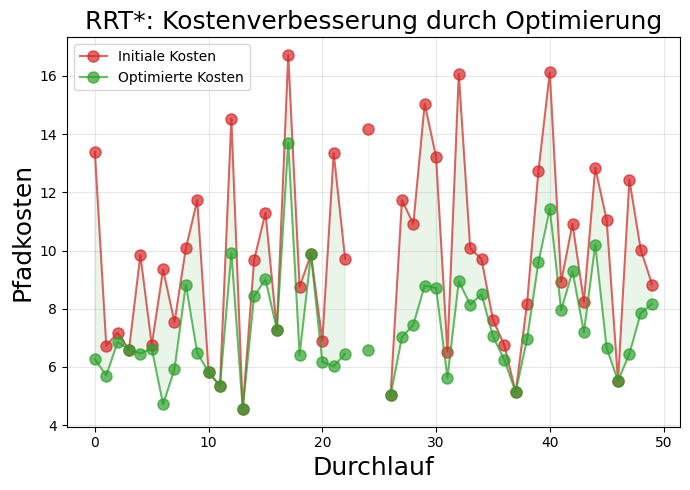

RRT* initial: 9.808361429894477
PRM* initial: 11.803855525197273
RRT* optimiert: 7.370666882588126
PRM* optimiert: 11.803855525197273


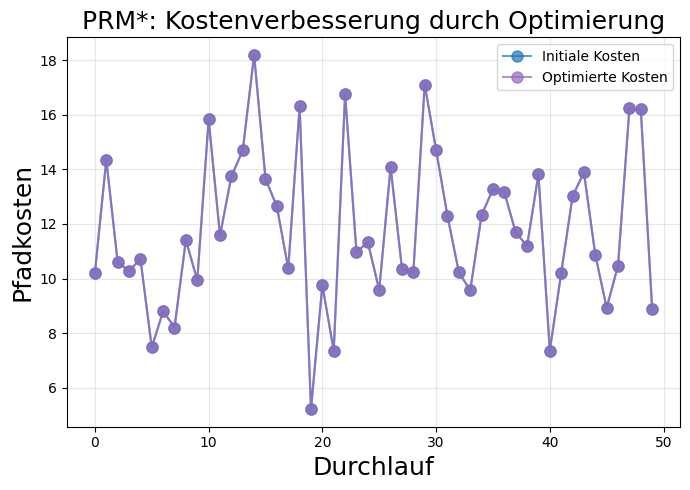

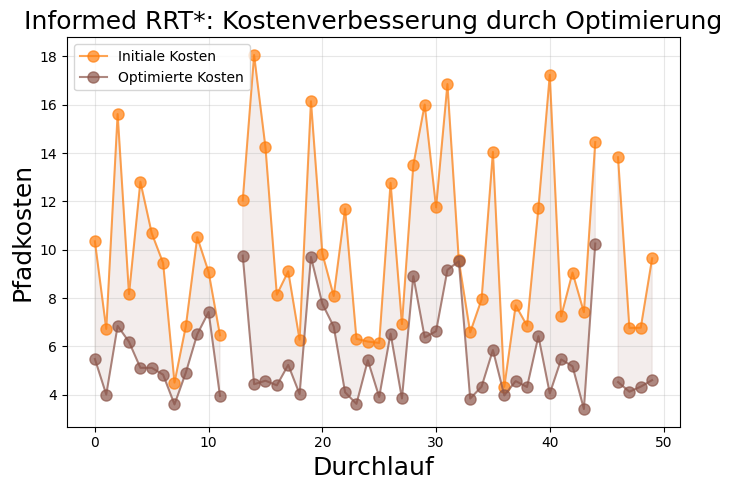

Informed RRT* initial: 10.049577449985575
Informed RRT* optimiert: 5.581118123626208


In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Daten laden
rrt_df = pd.read_csv("run_summary_rrtstar.csv")
prm_df = pd.read_csv("run_summary_prmstar.csv")
irrt_df = pd.read_csv("run_summary_informedrrtstar.csv")

# Plot für RRT*
plt.figure(figsize=(7, 5))
plt.plot(rrt_df["initial_cost"], 'o-', color='tab:red', label='Initiale Kosten', alpha=0.7, markersize=8)
plt.plot(rrt_df["cost"], 'o-', color='tab:green', label='Optimierte Kosten', alpha=0.7, markersize=8)

plt.fill_between(np.arange(len(rrt_df)),
                 rrt_df["initial_cost"],
                 rrt_df["cost"],
                 color='tab:green', alpha=0.1)
plt.title("RRT*: Kostenverbesserung durch Optimierung", fontsize=18)
plt.xlabel("Durchlauf", fontsize=18)
plt.ylabel("Pfadkosten", fontsize=18)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("rrt_cost_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Mittelwerte ausgeben
print("RRT* initial:", rrt_df["initial_cost"].mean())
print("PRM* initial:", prm_df["initial_cost"].mean())  # <-- Du hattest hier einen Tippfehler: "ininitial_cost"
print("RRT* optimiert:", rrt_df["cost"].mean())
print("PRM* optimiert:", prm_df["cost"].mean())

# Plot für PRM*
plt.figure(figsize=(7, 5))
plt.plot(prm_df["initial_cost"], 'o-', color='tab:blue', label='Initiale Kosten', alpha=0.7, markersize=8)
plt.plot(prm_df["cost"], 'o-', color='tab:purple', label='Optimierte Kosten', alpha=0.7, markersize=8)

plt.fill_between(np.arange(len(prm_df)),
                 prm_df["initial_cost"],
                 prm_df["cost"],
                 color='tab:purple', alpha=0.1)
plt.title("PRM*: Kostenverbesserung durch Optimierung", fontsize=18)
plt.xlabel("Durchlauf", fontsize=18)
plt.ylabel("Pfadkosten", fontsize=18)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("prm_cost_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot für Informed RRT*
plt.figure(figsize=(7, 5))
plt.plot(irrt_df["initial_cost"], 'o-', color='tab:orange', label='Initiale Kosten', alpha=0.7, markersize=8)
plt.plot(irrt_df["cost"], 'o-', color='tab:brown', label='Optimierte Kosten', alpha=0.7, markersize=8)

plt.fill_between(np.arange(len(irrt_df)),
                 irrt_df["initial_cost"],
                 irrt_df["cost"],
                 color='tab:brown', alpha=0.1)
plt.title("Informed RRT*: Kostenverbesserung durch Optimierung", fontsize=18)
plt.xlabel("Durchlauf", fontsize=18)
plt.ylabel("Pfadkosten", fontsize=18)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("informed_rrt_cost_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Mittelwerte für Informed RRT*
print("Informed RRT* initial:", irrt_df["initial_cost"].mean())
print("Informed RRT* optimiert:", irrt_df["cost"].mean())


/tmp/ipykernel_15805/3777998877.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


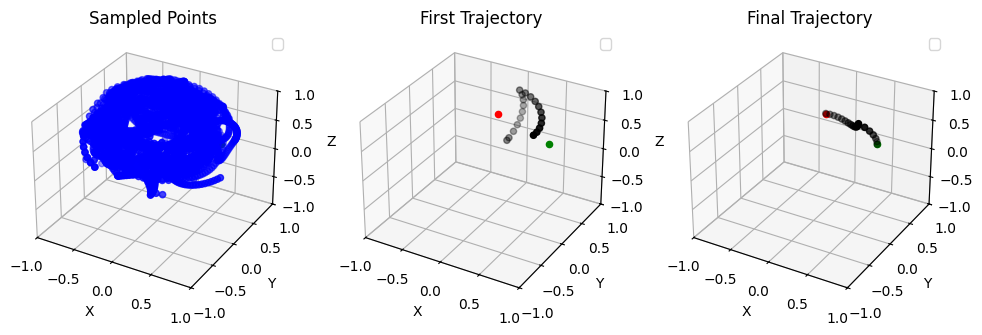

3304


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


def plot_xyz(x, y, z, start_xyz, goal_xyz, tested_points= None):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    firx = fig.add_subplot(1, 3, 2, projection='3d')
    finx = fig.add_subplot(1, 3, 3, projection='3d')
    configure_3d_axes(ax)
    configure_3d_axes(firx)
    configure_3d_axes(finx)
    ax.set_title("Sampled Points")
    firx.set_title("First Trajectory")
    finx.set_title("Final Trajectory")

    start_xyz = np.array(start_xyz)
    goal_xyz = np.array(goal_xyz)

    first_traj= np.load("first_sol.npy")
    first_traj_full =[]
    first_traj_fk =[]
    for i in range(len(first_traj)):
        first_traj_full.append(franka_chain.active_to_full(first_traj[i], np.zeros(len(franka_chain.links))))
        first_traj_fk.append(franka_chain.forward_kinematics(first_traj_full[i]))

    first_sol = np.array([traj[0:3, 3] for traj in first_traj_fk])

    final_traj= np.load("ompl_angles.npy")
    full_traj =[]
    final_traj_fk =[]
    for i in range(len(final_traj)):
        full_traj.append(franka_chain.active_to_full(final_traj[i], np.zeros(len(franka_chain.links))))
        final_traj_fk.append(franka_chain.forward_kinematics(full_traj[i]))

    final_sol = np.array([traj[0:3, 3] for traj in final_traj_fk])



    # if tested_points is not None:
    #     ax.scatter(tested_points[0], tested_points[1], tested_points[2], c='gray', marker='.', alpha=0.3, label='Checked points')


    # Geplante Punkte + Start + Ziel
    ax.scatter(x, y, z, c='b', marker='o', label='Tested Points',zorder=1)
    ax.scatter(start_xyz[0], start_xyz[1], start_xyz[2], c='r', marker='o', label='Start')
    ax.scatter(goal_xyz[0], goal_xyz[1], goal_xyz[2], c='g', marker='o', label='Goal')

     # Erste gelöste Trajektorie + Start + Ziel
    firx.scatter(first_sol[:, 0], first_sol[:, 1], first_sol[:, 2], c='black', marker='o', label='First Trajectory', zorder=5)
    firx.scatter(start_xyz[0], start_xyz[1], start_xyz[2], c='r', marker='o', label='Start')
    firx.scatter(goal_xyz[0], goal_xyz[1], goal_xyz[2], c='g', marker='o', label='Goal')

    # Finale Trajektorie + Start + Ziel
    finx.scatter(final_sol[:, 0], final_sol[:, 1], final_sol[:, 2], c='black', marker='o', label='Final Trajectory', zorder=5)
    finx.scatter(start_xyz[0], start_xyz[1], start_xyz[2], c='r', marker='o', label='Start')
    finx.scatter(goal_xyz[0], goal_xyz[1], goal_xyz[2], c='g', marker='o', label='Goal')

    plt.show()
    print(len(x))

def configure_3d_axes(ax):
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.legend()


plot_xyz(all_x, all_y, all_z, [0.1, 0.1, 0.85], [0.65, 0.3, 0.4])

/tmp/ipykernel_15805/2417666981.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


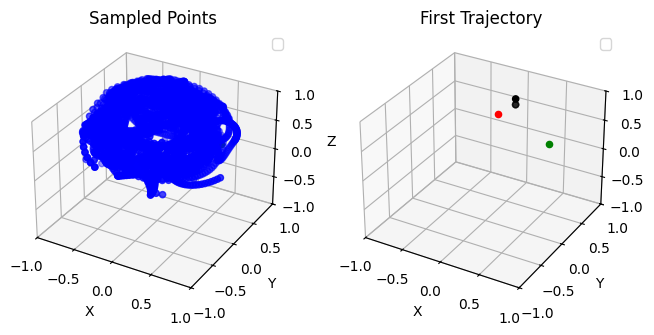

3304


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import ast


def plot_xyz(x, y, z, start_xyz, goal_xyz, tested_points= None):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    firx = fig.add_subplot(1, 3, 2, projection='3d')
    configure_3d_axes(ax)
    configure_3d_axes(firx)

    ax.set_title("Sampled Points")
    firx.set_title("First Trajectory")


    start_xyz = np.array(start_xyz)
    goal_xyz = np.array(goal_xyz)

    rrt = pd.read_csv("ompl_results_env4/run_summary_RRTstar.csv")
    rrt = rrt[rrt["path"].notna()]
    first_traj = [ast.literal_eval(traj_str) for traj_str in rrt["path"]]
    first_traj_full =[]
    first_traj_fk =[]
    for i in range(len(first_traj)):
        first_traj_full.append(franka_chain.active_to_full(first_traj[i], np.zeros(len(franka_chain.links))))
        first_traj_fk.append(franka_chain.forward_kinematics(first_traj_full[i]))

    first_sol = np.array([traj[0:3, 3] for traj in first_traj_fk])



    # if tested_points is not None:
    #     ax.scatter(tested_points[0], tested_points[1], tested_points[2], c='gray', marker='.', alpha=0.3, label='Checked points')


    # Geplante Punkte + Start + Ziel
    ax.scatter(x, y, z, c='b', marker='o', label='Tested Points',zorder=1)
    ax.scatter(start_xyz[0], start_xyz[1], start_xyz[2], c='r', marker='o', label='Start')
    ax.scatter(goal_xyz[0], goal_xyz[1], goal_xyz[2], c='g', marker='o', label='Goal')

     # Erste gelöste Trajektorie + Start + Ziel
    firx.scatter(first_sol[:, 0], first_sol[:, 1], first_sol[:, 2], c='black', marker='o', label='First Trajectory', zorder=5)
    firx.scatter(start_xyz[0], start_xyz[1], start_xyz[2], c='r', marker='o', label='Start')
    firx.scatter(goal_xyz[0], goal_xyz[1], goal_xyz[2], c='g', marker='o', label='Goal')


    plt.show()
    print(len(x))

def configure_3d_axes(ax):
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.legend()


plot_xyz(all_x, all_y, all_z, [0.1, 0.1, 0.85], [0.65, 0.3, 0.4])

In [ ]:
states = np.load("tested_joint_states.npy")
print(len(states))


254


In [ ]:
import numpy as np

def load_waypoints():
    # Wegpunkte aus Datei laden
    waypoints = []
    with open("output.txt", "r") as f:
        for line in f:
            if line.strip():
                x, y, z = map(float, line.strip().split())
                waypoints.append(np.array([x, y, z]))
    return waypoints
    print(waypoints)
print(load_waypoints())

ValueError: too many values to unpack (expected 3)

In [ ]:
def interpolate_trajectory(anglelist, steps_per_segment=20):
    interpolated = []
    for i in range(len(anglelist) - 1):
        start = np.array(anglelist[i])
        end = np.array(anglelist[i + 1])
        segment = np.linspace(start, end, steps_per_segment, endpoint=False)
        interpolated.extend(segment)
    interpolated.append(anglelist[-1])  # letzter Punkt anhängen
    return np.array(interpolated)


In [ ]:
# objekte in simulation/ andere objekte in pfadplanung
# mehr Pfadpunkte kalkulieren
# TCP nach unten gerichtet
# Kolision von Roboter vermeiden
# pick and place komplett modellieren
# statt txt export mit Api arbeiten
